# Sections

[Objective](#Objective)  
[Setup](#Setup)  
[Load data](#Load-data)  
[Scratchpad](#Scratchpad)

# Objective
[Back to top](#Sections)

#### How much interest will a new rental listing on RentHop receive?

In this Kaggle <a href='https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/data'>competition</a>, the aim is to predict how popular an apartment rental listing is based on the listing content like text description, photos, number of bedrooms, price, etc.

This workbook explores whether there are any insights to be gained from the text descripiton.

#  Setup
[Back to top](#Sections)

In [87]:
from __future__ import print_function, division

In [461]:
from collections import namedtuple
from collections import OrderedDict
from collections import Counter
from collections import defaultdict
import numpy as np
import pandas as pd

Load functions for producing nicely formatted output.

In [89]:
# %load utils.py
from IPython.display import display, HTML

def pp_bold(str):
    display(HTML('<b>{}</b>'.format(str)))


def pp_listOflist(l):
    display(HTML(
        u'<table>{}</table>'.format(
            u''.join(u'<tr>{}</tr>'.format(
                u''.join(u'<td>{}</td>'.format(v) for v in sublist)) for sublist in l))))
    

def pp_dict(d, rows=None):
    if not rows or rows >= len(d):
        display(HTML(
            u'<table>{}</table>'.format(
                u''.join(u'<tr><td><b>{}</b></td><td>{}</td></tr>'.format(k, d[k]) for k in d))))
    else:
        nitems = len(d)
        width = -(-nitems // rows)
        i = 0
        list_ = [[] for _ in range(rows)]
        for _ in range(width):
            for row in range(rows):
                if i < nitems:
                    k, v = d.items()[i]
                    list_[row].extend(['<b>{}</b>'.format(k), v])
                i += 1
        pp_listOflist(list_)


def pp_dictOflist(d):
    display(HTML(
        u'<table>{}</table>'.format(
            u''.join(u'<tr><td><b>{}</b></td>{}</tr>'.format(k,
                u''.join(u'<td>{}</td>'.format(v) for v in d[k])) for k in d.keys()))))
    

def pp_dfinfo(df, width=4):
    ncols = len(df.columns)
    width = min(width, ncols)
    depth = -(-ncols // width)
    i = 0
    list_ = [[] for _ in range(depth)]
    for _ in range(width):
        for row in range(depth):
            if i < ncols:
                col = df.columns[i]
                list_[row].extend(['<b>{}</b>'.format(col), df[col].count(), df.dtypes[i]])
            i += 1

    print('{} entries, {} columns'.format(len(df), ncols))
    pp_listOflist(list_)


def pp_counts(series, rows=1, caption=None):
    if caption: pp_bold(caption)
    list_ = [(k, '{:.4f}'.format(v)) for k, v in series.to_dict().items()] 
    dict_ = OrderedDict(sorted(list_, key=lambda x: x[0]))
    pp_dict(dict_, rows)


def pp_progress(s):
    sys.stdout.write('\r{}'.format(s))
    sys.stdout.flush()


## Load data
[Back to top](#Sections)

In [90]:
import pymongo

In [92]:
client = pymongo.MongoClient('ec2-34-198-246-43.compute-1.amazonaws.com', 27017)
db = client.renthop
collection = db.listings
pp_bold('{} listings'.format(collection.count()))

Print one of them.

In [93]:
pp_dict(collection.find_one())

loc,"{u'type': u'Point', u'coordinates': [-73.9389, 40.7245]}"
listing_id,6818139
_id,58ac97520b0203c6b6436f4c
display_address,Hausman Street
description,"This one WON'T LAST!! Here is a stunning 3 Bedroom, 2 Full Bathroom apartment measuring approximately 1100 sqft! The layout is NOT a railroad with a King Sized master bedroom complete with on suite full bathroom and bay-windows. The 2nd and 3rd bedrooms can fit a Full or Queen sized bed and have over-sized windows. Thee is a second full bathroom with soaking tub off of the main hallway. Open concept kitchen with large island finished in real stone counters and soft close cabinetry plus Stainless Steel industrial sized appliances! Heated hardwood flooring throughout with tons of sunlight and space. Central HVAC means that you never have to be too hot or too cold again!One of the best locations for street parking in Greenpoint! Don't have a car? No Problem, the Nassau G Train and Grand St L train are within reach.Call, Text, Email Taylor now to schedule your private showing. Not exactly what you are looking for? Email me your search criteria, I Specialize in North Brooklyn!-------------Listing courtesy of Miron Properties. All material herein is intended for information purposes only and has been compiled from sources deemed reliable. Though information is believed to be correct, it is presented subject to errors, omissions, changes or withdrawal without notice. Miron Properties is a licensed Real Estate Broker. www.MironProperties.com<a website_redacted"
created,2016-04-03 02:22:45
price,2995
bedrooms,3
interest_level,medium
longitude,-73.9389
photos,https://photos.renthop.com/2/6818139_a50e80ff79c71a1ced4ec103985abdd9.jpg https://photos.renthop.com/2/6818139_a2be68c008aeff88347f97dc0350f85d.jpg https://photos.renthop.com/2/6818139_63166d3d69203d7bd63e8e8bb47db8c6.jpg https://photos.renthop.com/2/6818139_1aba230faec5ed91372bb3996b98acf1.jpg https://photos.renthop.com/2/6818139_af28eb103bab59ec9d929c3657d846e6.jpg https://photos.renthop.com/2/6818139_3637c3737c1286332310476fa4d5b1d8.jpg https://photos.renthop.com/2/6818139_83f4bfb1928581fb9feec154629f62e9.jpg


### Add MongoDB geospatial index

Listings have distince 'longitude' and 'latitude' fields. Combine these into an indexed 'loc' field that is compatible with mongoDB's geospatial query operations. To avoid doing this more than once, check first if the index already exists.

In [94]:
from geojson import Point
%matplotlib inline

In [95]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

In [96]:
%%time
if not 'loc' in collection.find_one():
    cursor = collection.find({}, {'longitude':1, 'latitude':1})
    bulk = collection.initialize_ordered_bulk_op()
    for r in cursor:
        bulk.find({'_id' : r['_id']}).update({ '$set' : { 'loc' : Point((r['longitude'], r['latitude']))}})
    bulk.execute()
    collection.create_index([("loc", pymongo.GEOSPHERE)])

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 26.5 ms


### Examine prices in different areas

This helper function returns listings in a area defined by a center point and radius.

In [384]:
def find_near(point, distance=500, fields=None):
    result = list(collection.find({'loc' : {'$near' : { '$geometry' : point, '$maxDistance' : distance }}}, fields))
    if result and '_id' in result[0]:
        for r in result:
            r['_id'] = str(r['_id'])
    return result

Here I define some test locations around Manhattan and plot the prices around two of them. As you'd expect, the prices differ dramatically.

In [98]:
METIS_loc = Point((-73.9852, 40.7438))
SEVEN80_loc = Point((-73.9478, 40.8339))
TIMESSQ_loc = Point((-73.9851, 40.7589))
WESTVILLAGE_loc = Point((-73.9954, 40.7341))

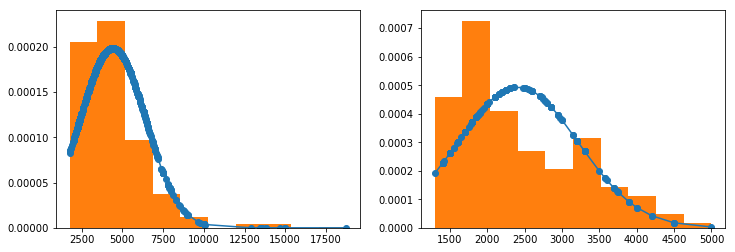

In [99]:
nearby_A = find_near(METIS_loc, 500, {'_id':0, 'price':1})
prices_A = sorted([x['price'] for x in nearby_A if x['price'] < 1e5])
nearby_B = find_near(SEVEN80_loc, 500, {'_id':0, 'price':1})
prices_B = sorted([x['price'] for x in nearby_B if x['price'] < 1e5])

plt.figure(figsize=(12, 4))
plt.subplot(121)
fit = stats.norm.pdf(prices_A, np.mean(prices_A), np.std(prices_A))
plt.plot(prices_A, fit,'-o')
plt.hist(prices_A, normed=True)

plt.subplot(122)
fit = stats.norm.pdf(prices_B, np.mean(prices_B), np.std(prices_B))
plt.plot(prices_B, fit,'-o')
plt.hist(prices_B, normed=True)

plt.show()

###  Linear regression with just size and location

To establish the baseline performance, apply linear regression using location and size alone to predict price. First, use the entire data set.

In [418]:
def get_data(columns, loc=None, distance=500):
    if loc:
        df = pd.DataFrame(find_near(loc, distance, columns), columns=columns)
    else:
        df = pd.DataFrame(list(collection.find({}, columns)), columns=columns)
    return df.drop(df[df.price>1e5].index).reset_index(drop=True) # drop price anomalies (see data_exploration.ipynb)

In [433]:
df = get_data(['latitude', 'longitude', 'price', 'bedrooms', 'bathrooms'])
ols = sm.OLS(df['price'], sm.add_constant(df.drop('price', axis=1))).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                 1.058e+04
Date:                Mon, 20 Mar 2017   Prob (F-statistic):               0.00
Time:                        13:50:31   Log-Likelihood:            -4.3917e+05
No. Observations:               49346   AIC:                         8.784e+05
Df Residuals:                   49341   BIC:                         8.784e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -393.0697    511.323     -0.769      0.442   -1395.269     609.130
latitude    -388.2645     48.948     -7.932      0.000    -484.204    -292.325
longitude   -215.6553     26.535     -8.127      0.000    -267.664    -163.647
bedrooms     331.6670      8.468     39.168      0.000     315.070     348.264
bathrooms   2820.6616     18.831    149.791      0.000    2783.753    2857.570
==============================================================================
Omnibus:                    85423.403   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        294897041.416
Skew:                          11.673   Prob(JB):                         0.00
Kurtosis:                     380.997   Cond. No.                     5.41e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Next, apply regression to listings within a specific area. Observe the performance is better and the model is more stable. This suggests location may be more useful as a way to separate listings into different clusters, rather than as a feature in the model. Further investigation, not shown here, supports this conclusion, so that's how we proceed.

In [441]:
df = get_data(['price', 'bedrooms', 'bathrooms'], TIMESSQ_loc)
X = sm.add_constant(df.drop('price', axis=1))
y = df['price']
ols = sm.OLS(y, X).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     445.5
Date:                Mon, 20 Mar 2017   Prob (F-statistic):          9.51e-131
Time:                        13:56:40   Log-Likelihood:                -6447.2
No. Observations:                 803   AIC:                         1.290e+04
Df Residuals:                     800   BIC:                         1.291e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1694.5249     71.219     23.793      0.000    1554.727    1834.323
bedrooms     634.3560     29.103     21.797      0.000     577.228     691.484
bathrooms    687.3297     63.265     10.864      0.000     563.144     811.516
==============================================================================
Omnibus:                      200.197   Durbin-Watson:                   1.303
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2917.443
Skew:                           0.699   Prob(JB):                         0.00
Kurtosis:                      12.233   Cond. No.                         7.19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Examine the residuls and Q-Q plot for this very simple model with just two-features.

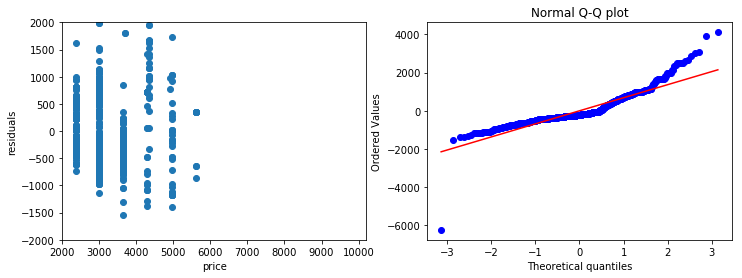

In [443]:
xs = range(len(y))
plt.figure(figsize=(12, 4))

y_pred = ols.predict(X)
plt.subplot(121)
plt.scatter(y_pred, ols.resid)
plt.ylim(-2000, 2000)
plt.xlabel('price')
plt.ylabel('residuals')

plt.subplot(122)
stats.probplot(ols.resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

### Linear regression with apartment features
Here we add the rental unit's features to the model.

First extract the top 50 features. See ```data_exploration.ipynb``` for the reasoning behind this logic.

In [444]:
import json
with open('synonyms.json') as fd:
    synomyns = json.load(fd)
canon = {alias : term for s in synomyns for term, aliases in s.items() for alias in aliases}

all_features = Counter()
df = pd.DataFrame(list(collection.find({}, ['features'])))
for l in df.features:
    unit_features = l.lower().replace('-', ' ').split('\n')
    all_features.update([canon.get(f, f) for f in unit_features if f])

top50 = dict(all_features.most_common(50))

This helper function splits the feature lists into a matrix where each feature is a separate column.

In [445]:
def get_features_matrix(list_or_iter):
    listings = []
    for features in list_or_iter:
        listings.append({})
        for f in features.lower().replace('-', ' ').split('\n'):
            f = canon.get(f, f)
            if f in top50:
                f_name = 'f_' + f.replace(' ', '_')
                listings[-1][f_name] = 1    
    return pd.DataFrame.from_dict(listings).fillna(0)

Create model with all apartment features. Observe the performance is much improved, but the model is unstable and not all features are significant.

In [506]:
df = get_data(['price', 'bedrooms', 'bathrooms', 'features'], TIMESSQ_loc)
df = df.join(get_features_matrix(df.features)).drop('features', axis=1)

X = sm.add_constant(df.drop('price', axis=1))
y = df['price']

ols = sm.OLS(y, X).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     50.95
Date:                Mon, 20 Mar 2017   Prob (F-statistic):          1.60e-174
Time:                        15:30:34   Log-Likelihood:                -6265.3
No. Observations:                 803   AIC:                         1.260e+04
Df Residuals:                     767   BIC:                         1.277e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

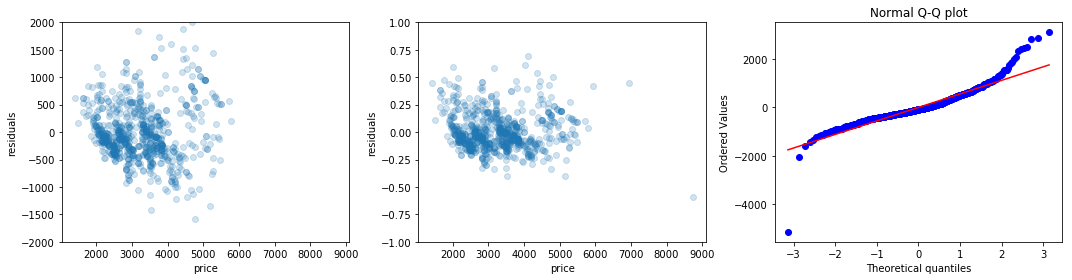

In [510]:
xs = range(len(y))
plt.figure(figsize=(15, 4))

y_pred = ols.predict(X)
resids = ols.resid

plt.subplot(131)
plt.scatter(y_pred, resids, alpha=.2)
plt.ylim(-2000, 2000)
plt.xlabel('price')
plt.ylabel('residuals')

plt.subplot(132)
plt.scatter(y_pred, resids / y_pred, alpha=.2)
plt.ylim(-1.0, 1.0)
plt.xlabel('price')
plt.ylabel('residuals')

plt.subplot(133)
stats.probplot(ols.resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

plt.tight_layout()
plt.show()

### Cross-validate and regularize

Now that we have a direction, use cross-validation and regularization to create a robust model.

In [463]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV

 This helper function scores different regression algorithms.

In [486]:
def eval_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=4444)
    scores = {}

    ridge = RidgeCV(cv=5)
    ridge.fit(X_train, y_train)
    scores['Ridge'] = round(ridge.score(X_test, y_test), 3)

    lasso = LassoCV(cv=5)
    lasso.fit(X_train, y_train)
    scores['Lasso'] = round(lasso.score(X_test, y_test), 3)

    elnet = ElasticNetCV(cv=5)
    elnet.fit(X_train, y_train)
    scores['ElasticNet'] = round(elnet.score(X_test, y_test), 3)

    # Also try plain LinearRegression after using p-values to 
    # select important features.

    ols = sm.OLS(y_train, sm.add_constant(X_train)).fit()
    significant_features = [f for f in ols.pvalues.index if f != 'const' and ols.pvalues[f] < 0.01]
    ols_X_train = X_train[significant_features]
    ols_scores = cross_val_score(LinearRegression(), ols_X_train, y_train, cv=5, scoring='r2')
    scores['LinearRegression'] = np.round(np.mean(ols_scores), 3)
    return scores

Check the model performance on several Manhattan locations.

In [487]:
scores = defaultdict(list)
for loc in [TIMESSQ_loc, METIS_loc, SEVEN80_loc, WESTVILLAGE_loc]:
    df = get_data(['price', 'bedrooms', 'bathrooms', 'features'], loc)
    df = df.join(get_features_matrix(df.features)).drop('features', axis=1)
    X = df.drop('price', axis=1)
    y = df['price']
    for model, score in eval_models(X, y).items():
        scores[model].append(score)

pp_dictOflist(scores)

ElasticNet,0.447,0.38,0.675,0.158
Ridge,0.664,0.584,0.867,0.399
LinearRegression,0.484,0.573,0.832,0.671
Lasso,0.53,0.592,0.728,0.426


This chart illustrates how prices behave non-linearly.

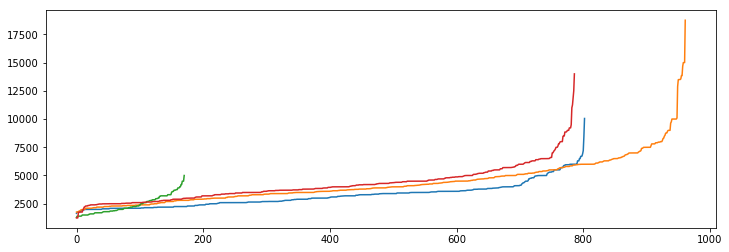

In [485]:
plt.figure(figsize=(12, 4))
for loc in [TIMESSQ_loc, METIS_loc, SEVEN80_loc, WESTVILLAGE_loc]:
    df = get_data(['price'], loc)
    df = df[df.price<20000].sort_values(by='price')
    plt.plot(range(len(df)), df.price)
plt.show()

 Maybe we need a log relationship in our model? It seems so, and now ElasticNet performs best of all the algorithms.

In [488]:
scores = defaultdict(list)
for loc in [TIMESSQ_loc, METIS_loc, SEVEN80_loc, WESTVILLAGE_loc]:
    df = get_data(['price', 'bedrooms', 'bathrooms', 'features'], loc)
    df = df.join(get_features_matrix(df.features)).drop('features', axis=1)
    X = df.drop('price', axis=1)
    y = np.log10(df['price'])
    for model, score in eval_models(X, y).items():
        scores[model].append(score)

pp_dictOflist(scores)

ElasticNet,0.711,0.701,0.901,0.66
Ridge,0.712,0.698,0.896,0.66
LinearRegression,0.638,0.657,0.84,0.646
Lasso,0.712,0.701,0.891,0.66


Examine the residuals and Q-Q plot of the "log price" ElasticNet model, and the normal price model.

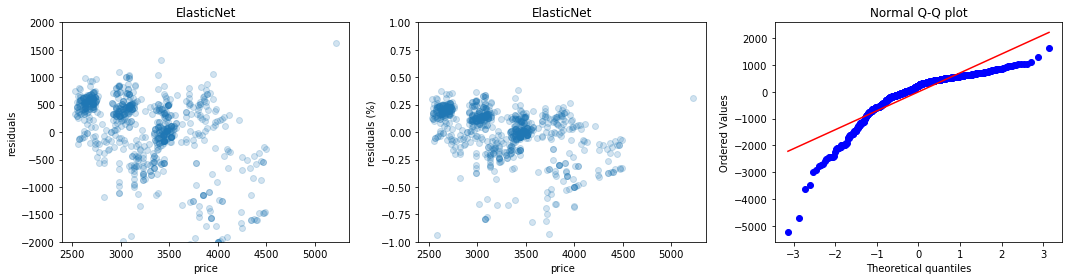

In [526]:
df = get_data(['price', 'bedrooms', 'bathrooms', 'features'], TIMESSQ_loc)
df = df.join(get_features_matrix(df.features)).drop('features', axis=1)

X = df.drop('price', axis=1)
y = df['price']

elnet = ElasticNetCV(cv=5)
elnet.fit(X, y)
y_pred = elnet.predict(X)
resids = y_pred - y

plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.scatter(y_pred, resids, alpha=.2)
plt.ylim(-2000, 2000)
plt.xlabel('price')
plt.ylabel('residuals')
plt.title('ElasticNet')

plt.subplot(132)
plt.scatter(y_pred, resids / y_pred, alpha=.2)
plt.ylim(-1.0, 1.0)
plt.xlabel('price')
plt.ylabel('residuals (%)')
plt.title('ElasticNet')

plt.subplot(133)
stats.probplot(resids, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.tight_layout()
plt.show()

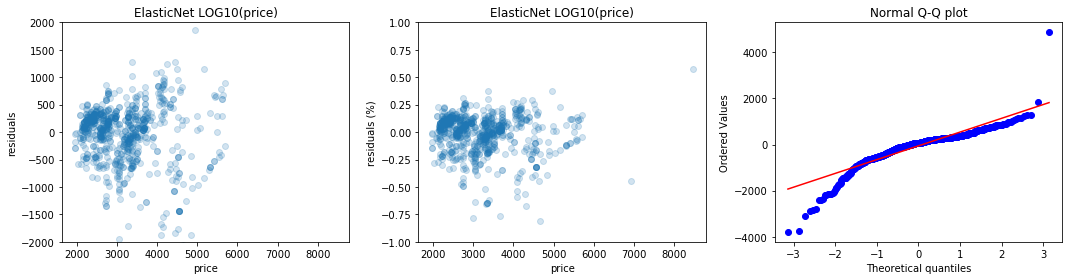

In [525]:
df = get_data(['price', 'bedrooms', 'bathrooms', 'features'], TIMESSQ_loc)
df = df.join(get_features_matrix(df.features)).drop('features', axis=1)

X = df.drop('price', axis=1)
y = df['price']

elnet = ElasticNetCV(cv=5)
elnet.fit(X, np.log10(y))
y_pred = np.power(10, elnet.predict(X))
resids = y_pred - y

plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.scatter(y_pred, resids, alpha=.2)
plt.ylim(-2000, 2000)
plt.title('ElasticNet LOG10(price)')
plt.xlabel('price')
plt.ylabel('residuals')

plt.subplot(132)
plt.scatter(y_pred, resids / y_pred, alpha=.2)
plt.ylim(-1.0, 1.0)
plt.xlabel('price')
plt.ylabel('residuals (%)')
plt.title('ElasticNet LOG10(price)')

plt.subplot(133)
stats.probplot(resids, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.tight_layout()
plt.show()

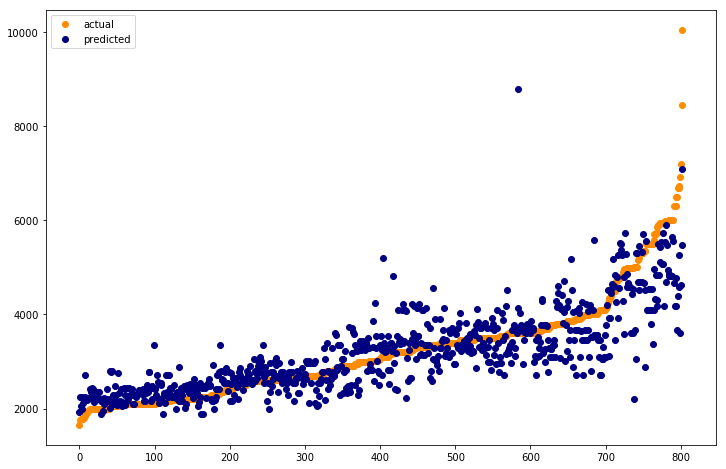

In [524]:
df = get_data(['price', 'bedrooms', 'bathrooms', 'features'], TIMESSQ_loc)
df = df.join(get_features_matrix(df.features)).drop('features', axis=1)
df = df.sort_values(by='price')

X = df.drop('price', axis=1)
y = df['price']

elnet = ElasticNetCV(cv=5)
elnet.fit(X, np.log10(y))
y_pred = np.power(10, elnet.predict(X))

xs = range(len(y))
plt.figure(figsize=(12, 8))
plt.scatter(xs, y, color='darkorange', label='actual')
plt.scatter(xs, y_pred, color='navy',label='predicted')
plt.legend()
plt.show()

# Scratchpad
[[back to top]](#Sections)

In [235]:
import math
def distance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [673]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
ols.predict(X[:1])

0    3353.887787
dtype: float64

In [671]:
prstd, iv_l, iv_u = wls_prediction_std(ols)

In [672]:
prstd[0], iv_l[0], iv_u[0]

(681.6337789375923, 2016.6366952889091, 4691.1388785928993)

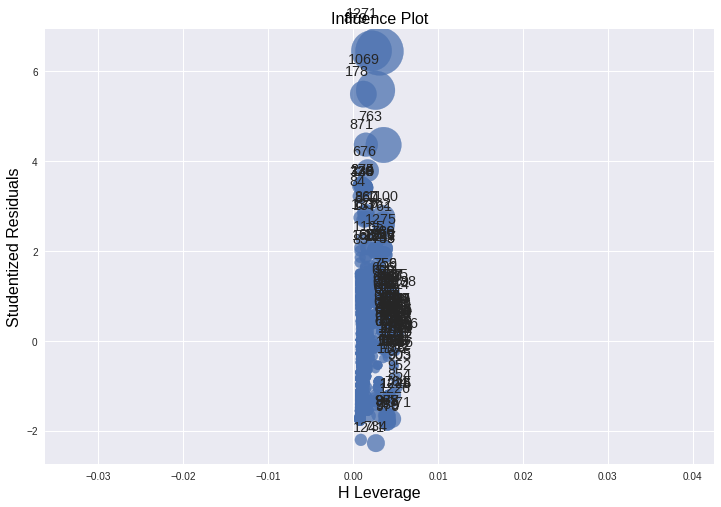

In [607]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(ols, ax=ax, criterion="cooks")

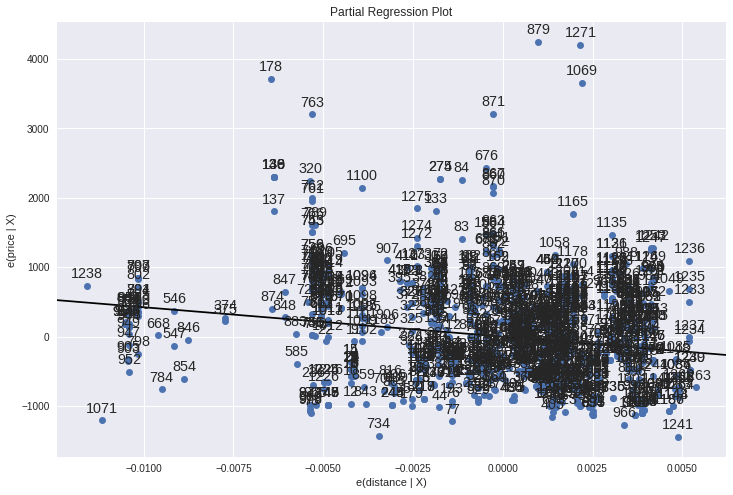

In [608]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.plot_partregress("price", "distance", ["longitude"], data=df, ax=ax)
#fig = sm.graphics.plot_partregress("price", "latitude", ["longitude"], data=df, ax=ax)

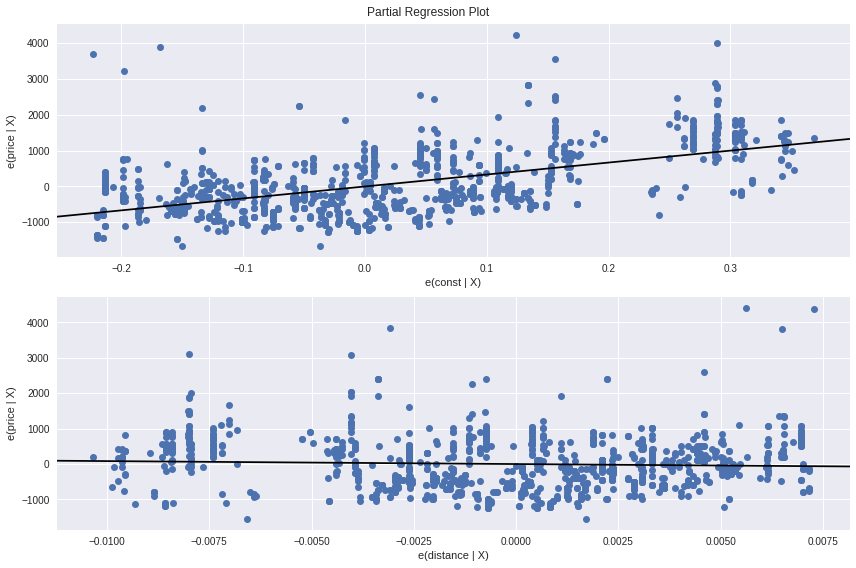

In [609]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(ols, fig=fig)

### Helper functions

This is a dumb predictor. It's used as a baseline for evaluating models. It always guesses the most common outcome in the training set. 

In [10]:
class Baseline(object):
    def __init__(self, guess=None):
        self.guess = guess
        
    def fit(self, X, Y):
        self.guess = Counter(Y).most_common(1)[0][0]
        pass
    
    def predict(self, X):
        pred = np.array([self.guess] * len(X))
        return pred        
    
    def score(self, X, Y):
        return metrics.accuracy_score(Y, self.predict(X))
    
    def get_params(self, deep=False):
        return {'guess': self.guess}